# Apartment Image Extraction Application

<hr>

### Parameters

In [1]:
### DEBUG
marker_model_path = '/lab/data/celldom/model/r0.2/marker_model/marker_model.h5'
chip_config_path = '/lab/repos/celldom/config/chip_01_config.json'
dataset_path = '/lab/data/celldom/dataset/dataset03'
use_chip_scaling = False
sample_size = 5
result_dir = '/lab/data/celldom/dataset/dataset03/ApartmentTraining'

In [11]:
# Parameters
marker_model_path = None
chip_config_path = None
dataset_path = None
result_dir = None

# Defaults
use_chip_scaling = False
sample_size = None

In [2]:
assert marker_model_path
assert chip_config_path
assert dataset_path
assert result_dir

<hr>

## Initialization

In [3]:
%matplotlib inline
import os
import os.path as osp
import json
import tempfile
import celldom
import glob
import skimage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import visualize as mrcnn_viz
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from celldom.preprocessing import marker_extraction
from celldom.preprocessing import apartment_extraction
from cvutils.mrcnn import model as mrcnn_model
from celldom import seed

pd.set_option('display.max_colwidth', 1000)
init_keras_session()
disable_mrcnn_warnings()
plt.gray()

tmp_model_dir = tempfile.gettempdir()
os.makedirs(result_dir, exist_ok=True)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

#### Configuration Intitialization

In [4]:
with open(chip_config_path, 'r') as fd:
    chip_config = json.load(fd)
    
print('Loaded chip configuration:\n', json.dumps(chip_config, indent=4))

Loaded chip configuration:
 {
    "apt_margins": {
        "bottom": 60,
        "right": 75,
        "left": 160,
        "top": 250
    },
    "name": "Chip 1",
    "target_scale_factor": 254.16,
    "apt_num_margins": {
        "bottom": -170,
        "right": 75,
        "left": 0,
        "top": 210
    }
}


In [5]:
inference_config = marker_config.MarkerInferenceConfig()
print('Loaded inference configuration:')
inference_config.display()

Loaded inference configuration:

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1408
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1408 1408    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_

#### Model Intitialization

In [6]:
print('Initializing marker detection model')
model = mrcnn_model.get_model('inference', inference_config, tmp_model_dir, init_with='file', file=marker_model_path)
print('Marker detection model initialization complete')

Initializing marker detection model
Marker detection model initialization complete


#### Dataset Intitialization

In [25]:

def get_data_files(path, pattern='*MOLM13*/*.tif'):
    files = glob.glob(osp.join(path, pattern))
    res = []
    for f in files:
        folder = osp.dirname(f).split(osp.sep)[-1]
        date, cells, cohort, conc, chip = folder.split()
        day = ''.join(date.split('.')[:3])
        date = date.replace('.', '')
        filename = osp.basename(f)
        address = '_'.join(filename.split('_')[:5])
        z = '_'.join(filename.split('_')[5:]).split('.')[0]
        res.append(dict(
            path=f, folder=folder, filename=filename, 
            date=date, day=day, cells=cells, cohort=cohort, 
            conc=conc, chip=chip, address=address, z=z
        ))
    return pd.DataFrame(res).sort_values('path')

In [26]:
data_files = get_data_files(dataset_path)
data_files.head()

,address,cells,chip,cohort,conc,date,day,filename,folder,path,z
6,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_z_0.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_z_0.tif,z_0
0,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif,zm3
1,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm6.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm6.tif,zm6
2,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm9.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm9.tif,zm9
3,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zp3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zp3.tif,zp3


In [27]:
#data_files.groupby(['day', 'cohort'])['address'].nunique()

In [28]:
from sklearn.model_selection import train_test_split

if sample_size is not None:
    # Assign groups to stratify on based on time (in days) and treatment/no treatment
    addresses = data_files['address'].drop_duplicates()
    if sample_size < 1:
        addresses = addresses.sample(frac=sample_size, random_state=seed)
    else:
        addresses = addresses.sample(n=min(len(addresses), sample_size), random_state=seed)
    
    print('Number of addresses selected: {}'.format(len(addresses)))
    # Subset data files to only those groups selected as part of the sample
    n_before = len(data_files)
    data_files = data_files[data_files['address'].isin(addresses.values)]
    print('Sampled original data files list down from {} records to {}'.format(n_before, len(data_files)))
    print('Day/Cohort group sizes:')
    print(data_files.groupby(['day', 'cohort']).size().sort_index())
else:
    print('No sample rate given so processing will proceed with all {} files'.format(len(data_files)))

Number of addresses selected: 5
Sampled original data files list down from 31759 records to 595
Day/Cohort group sizes:
day       cohort 
20180531  1nMQuiz     70
          NoDrug      70
20180601  1nMQuiz     70
          NoDrug     105
20180602  1nMQuiz     70
          NoDrug      70
20180603  NoDrug      70
20180604  NoDrug      70
dtype: int64


In [29]:
sample_address = addresses.iloc[0]
print('Example collections over time for sample address "{}":'.format(sample_address))
data_files[data_files['address'] == sample_address].groupby(['day', 'cohort', 'date']).size().unstack().T

Example collections over time for sample address "BF_ST_030_APT_032":


day          20180531        20180601        20180602        20180603 20180604
cohort        1nMQuiz NoDrug  1nMQuiz NoDrug  1nMQuiz NoDrug   NoDrug   NoDrug
date                                                                          
201805311610      NaN    7.0      NaN    NaN      NaN    NaN      NaN      NaN
201805311723      7.0    NaN      NaN    NaN      NaN    NaN      NaN      NaN
201805312109      NaN    7.0      NaN    NaN      NaN    NaN      NaN      NaN
201805312215      7.0    NaN      NaN    NaN      NaN    NaN      NaN      NaN
201806011045      NaN    NaN      NaN    7.0      NaN    NaN      NaN      NaN
201806011129      NaN    NaN      7.0    NaN      NaN    NaN      NaN      NaN
201806011622      NaN    NaN      NaN    7.0      NaN    NaN      NaN      NaN
201806011710      NaN    NaN      7.0    NaN      NaN    NaN      NaN      NaN
201806012307      NaN    NaN      NaN    7.0      NaN    NaN      NaN      NaN
201806020005      NaN    NaN      NaN    NaN      7.0    NaN      NaN      NaN
201806021029      NaN    NaN      NaN    NaN      NaN    7.0      NaN      NaN
201806021115      NaN    NaN      NaN    NaN      7.0    NaN      NaN      NaN
201806021725      NaN    NaN      NaN    NaN      NaN    7.0      NaN      NaN
201806030620      NaN    NaN      NaN    NaN      NaN    NaN      7.0      NaN
201806031845      NaN    NaN      NaN    NaN      NaN    NaN      7.0      NaN
201806040836      NaN    NaN      NaN    NaN      NaN    NaN      NaN      7.0
201806041820      NaN    NaN      NaN    NaN      NaN    NaN      NaN      7.0

In [158]:
#data_files = data_files.sample(n=500, random_state=seed)
#!find $dataset_path | head

In [30]:
dataset = marker_dataset.MarkerDataset()
dataset.initialize(data_files['path'].values)
dataset.prepare()

<hr>

## Extraction

In [31]:
def run_extraction(image, detections):
    
    ##################
    ## Extract Markers
    ##################
    
    # All RGB image channels should be equivalent before proceeding
    if not np.all(image[..., 0] == image[..., 1]):
        raise ValueError('Expecting greyscale RGB images with equal channels')
        
    # Use bounding box predictions to establish points as marker centers
    centers = marker_extraction.get_marker_centers(image[..., 0], detections['rois'])
    
    # Determine marker neighbors based on an angular offset threshold and proximity
    neighbors = marker_extraction.get_marker_neighbors(centers.values, angle_range=(-25, 25))
    
    ########################
    ## Apply Transformations
    ########################
    
    # Infer the overall rotation and scale of the image as the median of those same 
    # quantities determined for each adjacent marker pair
    rotation, scale = neighbors['angle'].median(), neighbors['distance'].median()
    
    # Apply the inferred transformations to the raw image (and marker locations since
    # they will be used as the basis for extracting necessary patches)
    scale_factor = None
    if use_chip_scaling:
        scale_factor = chip_config['target_scale_factor'] / scale    

    norm_image, norm_centers = apartment_extraction.apply_normalization(image, centers, rotation=rotation, scale=scale_factor)
    
    ################################
    ## Extract Around Marker Offsets
    ################################
    
    apt_images = apartment_extraction.extract_images(norm_image, norm_centers, chip_config)
    
    return apt_images, norm_image, norm_centers, neighbors, rotation, scale

In [70]:
def get_filename(record, marker_center, patch_idx):
    attrs = {k: record[k] for k in ['address', 'cohort', 'date', 'z']}
    my, mx = marker_center
    ry, rx = int(my / 100), int(mx / 100)
    attrs['my'], attrs['mx'], attrs['ry'], attrs['rx'] = my, mx, ry, rx
    attrs['patch_idx'] = patch_idx
    filename = '{address}-{cohort}-{ry:02d}-{rx:02d}-{date}-{z}-{my:04d}-{mx:04d}-{patch_idx:02d}.jpeg'.format(**attrs)
    return filename
    
def run_extractions(model, dataset, data_files, return_images=False, save_dir=None, image_ids=None):
    
    if image_ids is None:
        image_ids = dataset.image_ids
    n_ids = len(image_ids)
    
    extraction_summary = []
    for i, image_id in enumerate(image_ids):
        if i % max(len(image_ids) // 10, 1) == 0:
            print('Processing image {} of {} ({:.2f}%)'.format(i+1, n_ids, 100*(i+1)/n_ids))
            
        metadata = data_files.iloc[image_id].to_dict()
        image = dataset.load_image(image_id)

        detections = model.detect([image])[0]
        apt_images, norm_image, norm_centers, neighbors, rotation, scale = run_extraction(image, detections)
        
        record = dict(metadata)
        record['image_id'] = image_id
        record['scale'] = scale
        record['scales'] = neighbors['distance']
        record['rotation'] = rotation
        record['rotations'] = neighbors['angle']
        record['markers'] = [patch['marker_center'] for patch in apt_images]
        record['num_apartments'] = len(apt_images)
        record['num_markers'] = len(norm_centers)
        
        if save_dir is not None:
            for patch_idx, patch in enumerate(apt_images):
                filename = get_filename(record, patch['marker_center'], patch_idx)
                path = osp.join(save_dir, filename)
                
                apt_image = patch['apartment_image']
                # Extract first channel if multiple exist
                if apt_image.ndim == 3:
                    apt_image = apt_image[..., 0]
                assert apt_image.ndim == 2
                #print(path, apt_image.shape)
                skimage.io.imsave(path, apt_image)
        
        if return_images:
            record['normalized_image'] = norm_image[..., 0]
            record['raw_image'] = image[..., 0]
        extraction_summary.append(record)

    return pd.DataFrame(extraction_summary)

In [69]:
#!rm /lab/data/celldom/dataset/dataset03/ApartmentTraining/*.png
!du -d 0 -ch /lab/data/celldom/dataset/dataset03/ApartmentTraining/
#!ls /lab/data/celldom/dataset/dataset03/ApartmentTraining/*

313K	/lab/data/celldom/dataset/dataset03/ApartmentTraining/
313K	total


In [72]:
#extraction_summary = run_extractions(model, dataset, data_files, image_ids=[0,1,2,3,4,5,6], save_dir=result_dir)
extraction_summary = run_extractions(model, dataset, data_files, save_dir=result_dir)

Processing image 1 of 595 (0.17%)


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Processing image 60 of 595 (10.08%)
Processing image 119 of 595 (20.00%)
Processing image 178 of 595 (29.92%)
Processing image 237 of 595 (39.83%)
Processing image 296 of 595 (49.75%)
Processing image 355 of 595 (59.66%)
Processing image 414 of 595 (69.58%)
Processing image 473 of 595 (79.50%)
Processing image 532 of 595 (89.41%)
Processing image 591 of 595 (99.33%)


#### Extraction Summary Export

In [75]:
exp_path = osp.join(result_dir, 'analysis', 'extraction_summary.csv')
os.makedirs(osp.dirname(exp_path), exist_ok=True)
df = extraction_summary.drop(['markers', 'scales', 'rotations'], axis=1)
df.to_csv(exp_path, index=False)
print('Saved extraction summary to "{}"'.format(exp_path))
df.info()

Saved extraction summary to "/lab/data/celldom/dataset/dataset03/ApartmentTraining/analysis/extraction_summary.csv"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 16 columns):
address           595 non-null object
cells             595 non-null object
chip              595 non-null object
cohort            595 non-null object
conc              595 non-null object
date              595 non-null object
day               595 non-null object
filename          595 non-null object
folder            595 non-null object
image_id          595 non-null int64
num_apartments    595 non-null int64
num_markers       595 non-null int64
path              595 non-null object
rotation          595 non-null float64
scale             595 non-null float64
z                 595 non-null object
dtypes: float64(2), int64(3), object(11)
memory usage: 74.5+ KB


<hr>

## Extraction Summary Analysis

In [84]:
primary_cols = ['address', 'date', 'num_apartments', 'num_markers', 'rotation', 'scale', 'path']

In [76]:
extraction_summary[['scale', 'rotation']].describe()

,scale,rotation
count,595.000000,595.000000
mean,254.290397,0.451951
std,0.359670,0.335846
min,253.198239,-0.227123
25%,254.113095,0.234987
50%,254.200234,0.468232
75%,254.491158,0.684981
max,255.276663,1.030689


In [79]:
extraction_summary['num_markers'].value_counts()

17    304
8     226
18     32
16     21
7      12
Name: num_markers, dtype: int64

In [89]:
extraction_summary['num_apartments'].value_counts().rename('frequency').reset_index().rename(columns={'index': 'num_apartments'})

,num_apartments,frequency
0,13,334
1,6,238
2,14,23


In [104]:
extraction_summary[extraction_summary['num_apartments'] == 6][primary_cols].head(3)

,address,date,num_apartments,num_markers,rotation,scale,path
21,BF_ST_030_APT_006,201805311610,6,8,0.573411,254.210561,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_030_APT_006_z_0.tif
22,BF_ST_030_APT_006,201805311610,6,8,0.571455,254.276692,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_030_APT_006_zm3.tif
23,BF_ST_030_APT_006,201805311610,6,8,0.567887,254.278929,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_030_APT_006_zm6.tif


In [90]:
extraction_summary[extraction_summary['num_apartments'] == 14][primary_cols].head(3)

,address,date,num_apartments,num_markers,rotation,scale,path
84,BF_ST_024_APT_034,201805312109,14,18,0.690728,253.998986,/lab/data/celldom/dataset/dataset03/2018.05.31.2109 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_034_z_0.tif
85,BF_ST_024_APT_034,201805312109,14,18,0.691504,254.002172,/lab/data/celldom/dataset/dataset03/2018.05.31.2109 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_034_zm3.tif
86,BF_ST_024_APT_034,201805312109,14,18,0.686551,254.162104,/lab/data/celldom/dataset/dataset03/2018.05.31.2109 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_034_zm6.tif


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f125431aa58>],
      dtype=object)

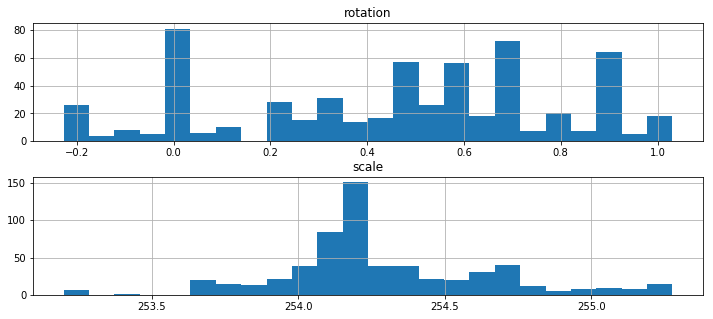

In [77]:
extraction_summary[['scale', 'rotation']].hist(layout=(2, 1), figsize=(12, 5), bins=24)

In [80]:
pd.set_option('display.max_colwidth', 1000)
extraction_summary[primary_cols].sort_values('rotation', ascending=False).head()

,address,date,num_apartments,num_markers,rotation,scale,path
270,BF_ST_030_APT_006,201806011710,6,7,1.030689,253.955304,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_030_APT_006_zp3.tif
264,BF_ST_024_APT_034,201806011710,13,16,1.023130,254.200234,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_024_APT_034_zp6.tif
252,BF_ST_015_APT_014,201806011710,13,16,1.018648,254.211720,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_015_APT_014_z_0.tif
256,BF_ST_015_APT_014,201806011710,13,16,1.017794,254.005158,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_015_APT_014_zp3.tif
260,BF_ST_024_APT_034,201806011710,13,16,1.017293,254.260038,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_024_APT_034_zm3.tif


Processing image 1 of 1 (100.00%)


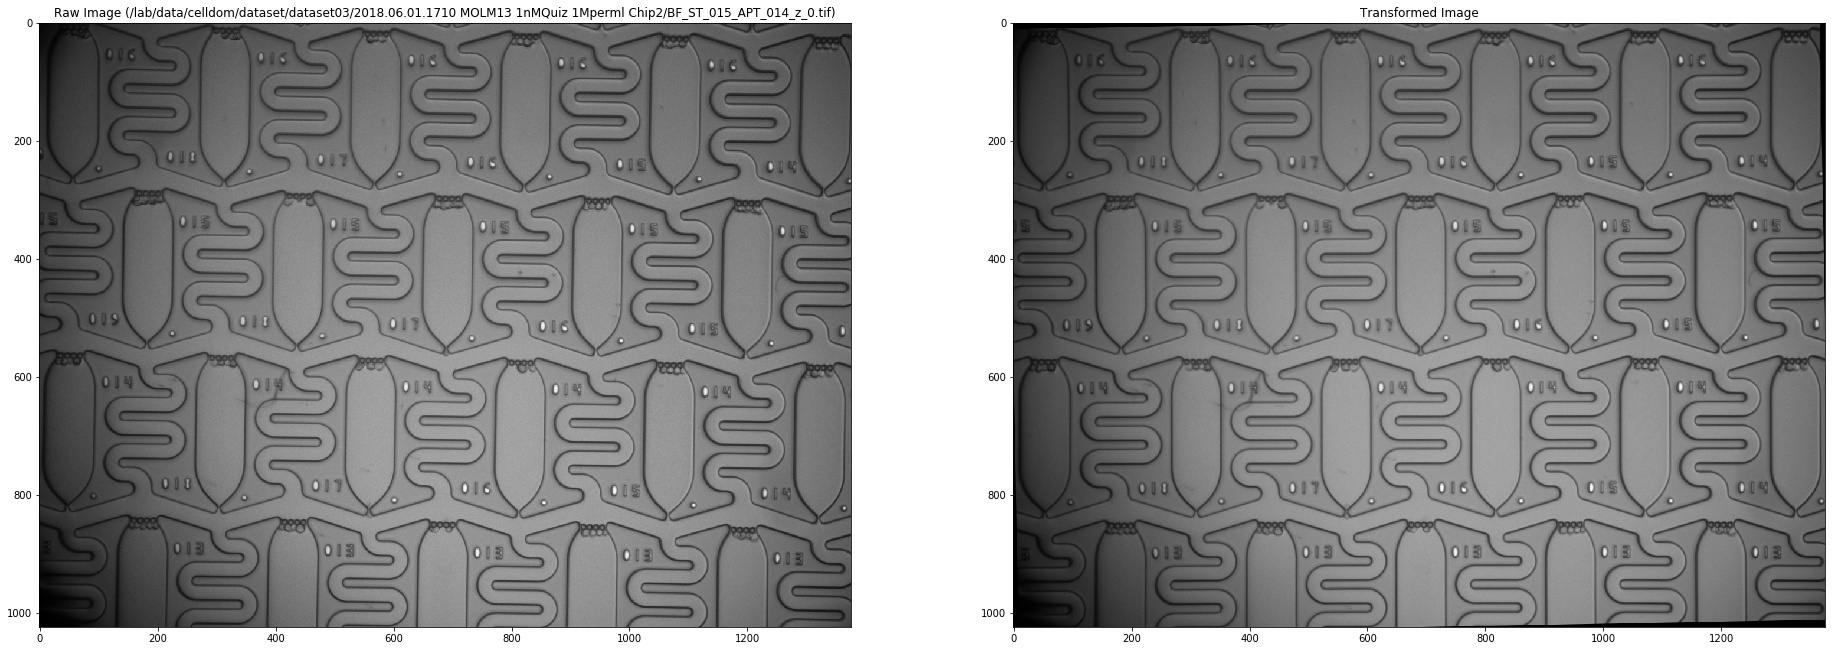

In [108]:
image_id = 252

df = run_extractions(model, dataset, data_files, return_images=True, image_ids=[image_id])
assert len(df) == 1
row = df.iloc[0]

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].imshow(row['raw_image'])
ax[0].set_title('Raw Image ({})'.format(row['path']))
ax[1].imshow(row['normalized_image'])
ax[1].set_title('Transformed Image')
plt.gcf().set_size_inches(32, 16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


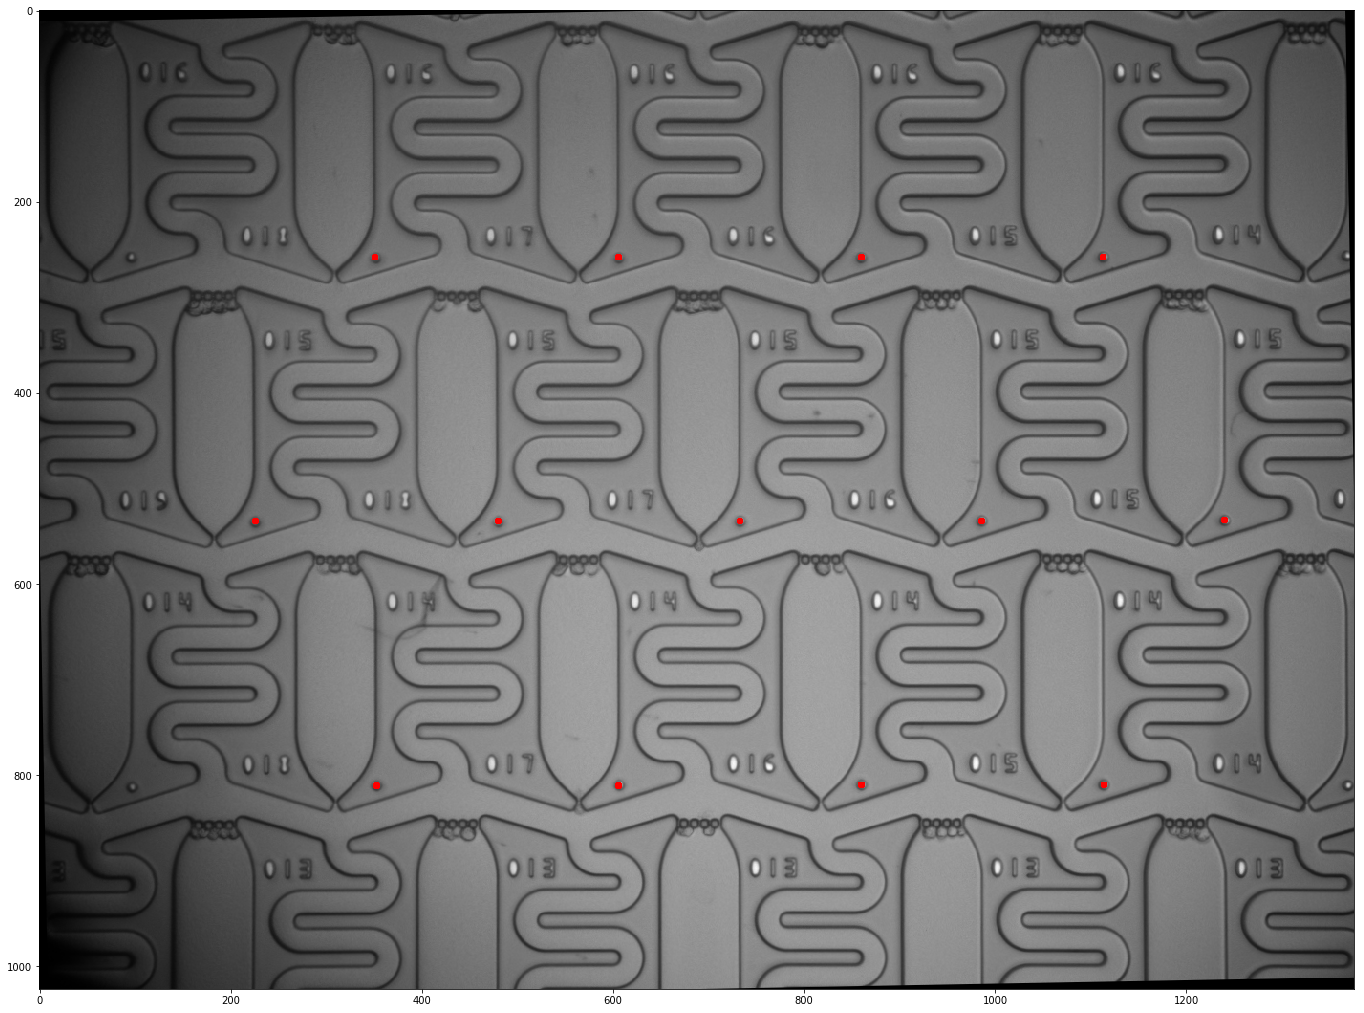

In [109]:
plt.imshow(marker_extraction.overlay_marker_centers(
    skimage.color.gray2rgb(row['normalized_image']), 
    pd.DataFrame(row['markers'], columns=['y', 'x']), 
    color=[255, 0, 0],
    radius=4
))
plt.gcf().set_size_inches(24, 18)